In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import datetime
from datetime import timedelta
import ast
import json    
import missingno as msno
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.impute import SimpleImputer
# from sklearn_pandas import CategoricalImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
# Helper packages
from plotnine import *

# Modeling packages
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


In [241]:
df = pd.read_csv('../data/ML_TEST.csv')
df['user_id'] = df['user_id'].astype('object')

In [242]:
df = df.drop(['user' , 'rega_id'] , axis=1)

In [243]:
df.columns

Index(['user_id', 'id', 'len_of_title', 'price', 'len_of_content',
       'img_in_poss', 'beds', 'livings', 'wc', 'area', 'street_width', 'age',
       'ketchen', 'ac', 'furnished', 'district', 'advertiser_type', 'review',
       'profileImg', 'iam_verified', 'DayOfRent', 'timeBeforeRent', 'onMarket',
       'zone', 'createYEAR', 'createMONTH', 'createDAY', 'lUpdateYEAR',
       'lUpdateMONTH', 'lUpdateDAY', 'isRent'],
      dtype='object')

after impliminting the ML model i decided to drop the creation and update column

In [244]:
df.drop(['createYEAR'],axis=1 ,inplace=True)
df.drop(['createDAY'],axis=1 ,inplace=True)
df.drop(['createMONTH'],axis=1 ,inplace=True)
df.drop(['lUpdateDAY'],axis=1 ,inplace=True)
df.drop(['lUpdateMONTH'],axis=1 ,inplace=True)
df.drop(['lUpdateYEAR'],axis=1 ,inplace=True)

## ready for Pipeline

delete low varince and outliers 

In [245]:
df = df[df['price'] <=100*1000]

In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6494 entries, 0 to 6622
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          6494 non-null   object 
 1   id               6494 non-null   int64  
 2   len_of_title     6494 non-null   int64  
 3   price            6494 non-null   int64  
 4   len_of_content   6494 non-null   int64  
 5   img_in_poss      6494 non-null   int64  
 6   beds             6494 non-null   int64  
 7   livings          6494 non-null   float64
 8   wc               6494 non-null   int64  
 9   area             6494 non-null   float64
 10  street_width     6494 non-null   float64
 11  age              6494 non-null   float64
 12  ketchen          6494 non-null   float64
 13  ac               6494 non-null   float64
 14  furnished        6494 non-null   float64
 15  district         6494 non-null   object 
 16  advertiser_type  6494 non-null   object 
 17  review        

In [247]:
nzv = VarianceThreshold(threshold=0.1)

dealing with Skewness

In [248]:
yj = PowerTransformer(method="yeo-johnson")
# X_norm = ColumnTransformer([("norm", yj, selector(dtype_include="number"))])

Standardization

In [249]:
scaler = StandardScaler()


# standardize all numeric features
# std = ColumnTransformer([("norm", scaler, selector(dtype_include="number"))])

OneHotEncoder for advertiser_type

In [250]:
encoder = OneHotEncoder(handle_unknown="ignore")


pca to try if it going to help 

In [251]:
# pca = PCA(n_components=14)


In [252]:
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("nzv_encode", nzv, selector(dtype_include="number")),
  ("norm", yj, selector(dtype_include="number")),
  ("std_encode", scaler, selector(dtype_include="number")),
  # ("pca_encode", pca, selector(dtype_include="number")),
  ("one-hot", encoder, selector(dtype_include="object")),
  ])

In [253]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('nzv_encode', VarianceThreshold(threshold=0.1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdb3f263c70>),
                                ('norm', PowerTransformer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdb3f261630>),
                                ('std_encode', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdb3f263bb0>),
                                ('one-hot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdb3f2639a0>)])

here i dropped DayOfRent becouse `isRent` is dependent on `DayOfRent` so there is no meaning on adding it (bias)

`timeBeforeRent` is also depedns on DayOfRent (dayOFrent - createDate)

for the `id`  when use it the accuracy increae ( becouse it is orderd)  as you can see 

In [254]:
temp = pd.read_csv('../data/aqar.csv')
temp[['id' , 'create_time'] ].sort_values(by='id')

,id,create_time
3866,211899,"['2016-05-26', '15:44:24']"
3830,779331,"['2017-11-23', '16:28:34']"
1703,825676,"['2017-12-30', '16:06:27']"
557,879567,"['2018-02-08', '19:20:10']"
533,1269068,"['2018-11-28', '16:02:25']"
...,...,...
491,4600178,"['2022-08-06', '12:05:24']"
1635,4600194,"['2022-08-06', '12:11:55']"
6710,4600222,"['2022-08-06', '12:21:15']"
26,4600237,"['2022-08-06', '12:24:50']"


we can see that the first id has the oldest creation date and the last id has the  date of my webscraping

but the reason of droping the value are they dont help the `project` 

even though it increases the accuracy but what i want to build is depending about the apartment you have and the featurs of the apartment (the age , the bedrooms , the price you want ... etc ) and i can't ask the user what is your id  and the same for `oMarket` feature i can't ask the user to enter how long it was in the market the user should use the model before he/she put it in the market 

In [255]:
X = df.drop(['isRent' , 'DayOfRent' , 'timeBeforeRent' ,  'id' , 'onMarket'  ] , axis=1)
y = df['isRent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# training & prediction


# k-fold = 5
# loss function = accurcy 

In [139]:
loss = 'accuracy'
k = 5 #k-fold

# logistic Regerssion

In [204]:
lr = LogisticRegression(max_iter=500)

model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("lr", lr),
])

In [205]:
model_pipeline.fit(X_train , y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nzv_encode',
                                                  VarianceThreshold(threshold=0.1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdb3ba5be20>),
                                                 ('norm', PowerTransformer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdb3ba5bb80>),
                                                 ('std_encode',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdb3ba5b8e0>),
                                                 ('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdb3ba5b580>)])),
                ('lr', LogisticRegression(max_iter=500))])

In [206]:
model_pipeline.score(X_test , y_test)

0.5972293483837866

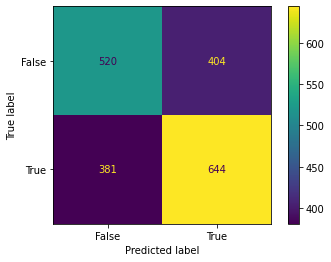

In [207]:
cm = confusion_matrix(y_test , model_pipeline.predict(X_test))
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=model_pipeline.classes_
  )
  
disp.plot()

# Random Forest


In [208]:
rf_mod = RandomForestClassifier()

# create modeling pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("rf_mod", rf_mod),
])

In [209]:
cb_reg_1 = model_pipeline.fit(X_train , y_train)

In [210]:
results =cross_val_score(cb_reg_1, X_test, y_test.values.ravel(), cv=k, scoring=loss)
np.abs(np.mean(results))

0.6829371827829412

In [96]:
model_pipeline.score(X_test , y_test)

0.704225352112676

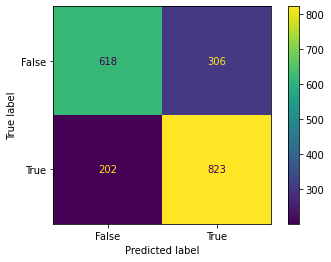

In [211]:
cm = confusion_matrix(y_test , model_pipeline.predict(X_test))
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=model_pipeline.classes_
  )
  
disp.plot()

In [212]:
print(classification_report(y_test,  model_pipeline.predict(X_test), target_names=["neg", "pos"]))

              precision    recall  f1-score   support

         neg       0.75      0.67      0.71       924
         pos       0.73      0.80      0.76      1025

    accuracy                           0.74      1949
   macro avg       0.74      0.74      0.74      1949
weighted avg       0.74      0.74      0.74      1949



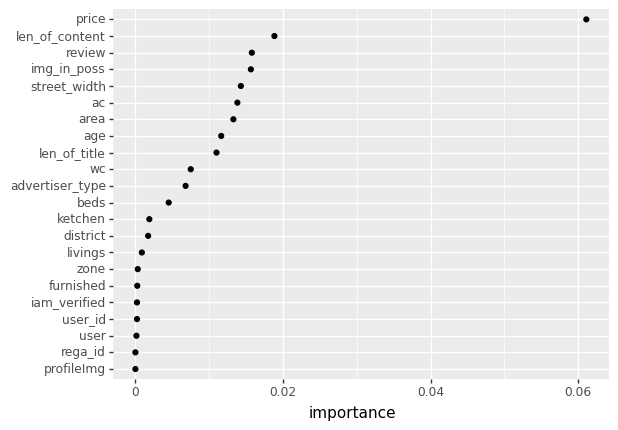

<ggplot: (8786227135648)>

In [213]:
r = permutation_importance(
  model_pipeline, 
  X_train, 
  y_train,
  n_repeats=30,
  random_state=0
  )
  
vip = pd.DataFrame({'feature': X_train.columns.values,
                    'importance': r.importances_mean})
                    
(ggplot(vip, aes('importance', 'reorder(feature, importance)'))
  + geom_point()
  + labs(y=None))

 # Decision Tree 

In [214]:
rf_mod = DecisionTreeClassifier()

In [215]:
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("rf_mod", rf_mod),
])

In [216]:
cb_reg_1  = model_pipeline.fit(X_train , y_train)

In [217]:
results =cross_val_score(cb_reg_1, X_test, y_test.values.ravel(), cv=k, scoring=loss)
np.abs(np.mean(results))

0.6305912596401029

In [218]:
cm = confusion_matrix(y_test , model_pipeline.predict(X_test))

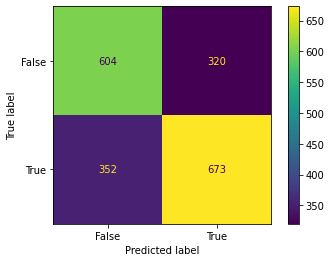

In [219]:
cm = confusion_matrix(y_test , model_pipeline.predict(X_test))
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=model_pipeline.classes_
  )
  
disp.plot()

In [220]:
print(classification_report(y_test,  model_pipeline.predict(X_test), target_names=["neg", "pos"]))

              precision    recall  f1-score   support

         neg       0.63      0.65      0.64       924
         pos       0.68      0.66      0.67      1025

    accuracy                           0.66      1949
   macro avg       0.65      0.66      0.65      1949
weighted avg       0.66      0.66      0.66      1949



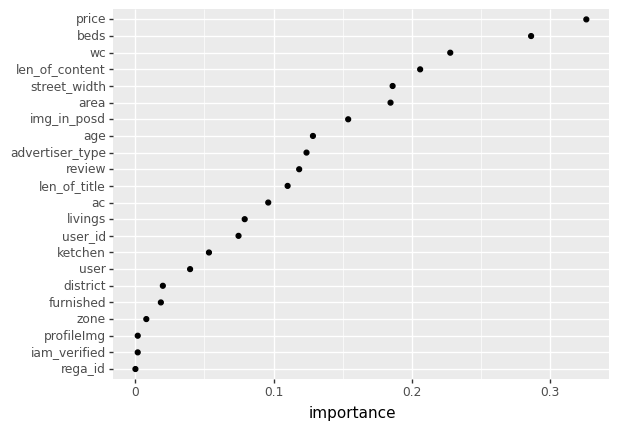

<ggplot: (8786406304826)>

In [160]:
r = permutation_importance(
  model_pipeline, 
  X_train, 
  y_train,
  n_repeats=30,
  random_state=0
  )
  
vip = pd.DataFrame({'feature': X_train.columns.values,
                    'importance': r.importances_mean})
                    
(ggplot(vip, aes('importance', 'reorder(feature, importance)'))
  + geom_point()
  + labs(y=None))

------

## i tried many models here and i used diffrent PCAs with cross validation

In [228]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
# from sklearn.linear_model import BaggingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV


In [222]:
X_train.shape

(4545, 22)

In [223]:

parameters = {
    'n_estimators'      : [320, 330 , 340 , 400 , 500 , 600 , 700],
    'max_depth'         : [8, 9, 10, 11, 12 , 20 , 30 ],
    'random_state'      : [0],
    #'max_features': ['auto'],
    #'criterion' :['gini']
}

In [230]:
ax = pd.DataFrame()
ax['methodName'] = ''
ax['PCA'] = ''
ax['accurcy'] = ''
# X = df.drop(['isRent' , 'DayOfRent' , 'timeBeforeRent' ,  'id' , 'onMarket'  ] , axis=1)

# X = df[['price' , 'img_in_posd' ,'beds' ,'livings', 'wc', 'area', 'age' ,'ketchen', 'ac', 'furnished', 'district', 'advertiser_type', 'review', 'zone']]

# y = df['isRent']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
for i in range(5,50,2):
  
  try:
      # scaler = StandardScaler()
      # yj = PowerTransformer(method="yeo-johnson")
      # nzv = VarianceThreshold(threshold=0.1)
      # encoder = OneHotEncoder(handle_unknown="ignore")
      pca = PCA(n_components=i)
      # cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )


      # training & prediction
      preprocessor = ColumnTransformer(
        remainder="passthrough",
        transformers=[
        ("nzv_encode", nzv, selector(dtype_include="number")),
        ("norm", yj, selector(dtype_include="number")),
        ("std_encode", scaler, selector(dtype_include="number")),
        ("pca_encode", pca, selector(dtype_include="number")),
        ("one-hot", encoder, selector(dtype_include="object")),
        ])


      classifiers = [
          KNeighborsClassifier(3),
          SVC(kernel="rbf", C=0.025, probability=True),
          NuSVC(probability=True),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=5,max_depth=1,min_samples_leaf=3, max_features=6, random_state=42),
          # RandomizedSearchCV(
          #       estimator=pipeline['clf'],
          #     param_distributions=parameter_grid,
          #     n_iter=number_models,
          #     scoring='accuracy',
          #     n_jobs=2,
          #     cv=4,
          #     refit=True,
          #     return_train_score=True),
          AdaBoostClassifier(),
          GradientBoostingClassifier(),
          GaussianNB(),
          LinearDiscriminantAnalysis(),
          QuadraticDiscriminantAnalysis(),
          ExtraTreesClassifier(**parameters),
          # SGDClassifier(),
          # Perceptron(),
          # LinearSVC(),
          LogisticRegressionCV(),
          PassiveAggressiveClassifier(),
          BernoulliNB(),
          LogisticRegression()
          
          ]

      # Logging for Visual Comparison
      log_cols=["Classifier", "Accuracy", "Log Loss"]
      log = pd.DataFrame(columns=log_cols)

      for clf in classifiers:
          # clf1 = GridSearchCV(clf, parameters, cv=5, n_jobs=-1)
          
          model_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("clf", clf),
          ])
          model_pipeline.fit(X_train, y_train)
          name = clf.__class__.__name__
          results =cross_val_score(cb_reg_1, X_test, y_test.values.ravel(), cv=k, scoring=loss)
          acc = np.abs(np.mean(results))
          # print("="*30)
          # print(name)
          
          # print('****Results****')
          # train_predictions = model_pipeline.predict(X_test)
          # acc = accuracy_score(y_test, train_predictions)
          ax = ax.append({'methodName' : name , 'PCA' : i, 'accurcy' : acc*100}, ignore_index = True)
  except:
    i=23
        # print("Accuracy: {:.4%}".format(acc))
        
        # train_predictions = model_pipeline.predict_proba(X_test)
        # ll = log_loss(y_test, train_predictions)
        # print("Log Loss: {}".format(ll))
        
        # log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
        # log = log.append(log_entry)
        
        # print("="*30 , i,"PCA")

/tmp/ipykernel_715/2803369050.py:86: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_715/2803369050.py:86: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_715/2803369050.py:86: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_715/2803369050.py:86: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_715/2803369050.py:86: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_715/2803369050.py:86: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future versi

In [231]:
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("nzv_encode", nzv, selector(dtype_include="number")),
  ("norm", yj, selector(dtype_include="number")),
  ("std_encode", scaler, selector(dtype_include="number")),
  # ("pca_encode", pca, selector(dtype_include="number")),
  ("one-hot", encoder, selector(dtype_include="object")),
  ])


GaussianProcessClassifier
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
XGBClassifier

In [235]:
ax[ax['PCA'] == ax.PCA.max()]

,methodName,PCA,accurcy
35,KNeighborsClassifier,15,63.006921
36,SVC,15,62.700020
37,NuSVC,15,62.340123
38,DecisionTreeClassifier,15,62.956035
39,RandomForestClassifier,15,62.853339
40,AdaBoostClassifier,15,62.802188
41,GradientBoostingClassifier,15,62.802320


In [233]:
import plotly.express as px
# df = px.data.gapminder()
fig = px.scatter(ax, x="PCA", y="accurcy", color="methodName" , log_x=True, size_max=60)
fig.show()

Text(0.5, 257.44, 'Predicted label')

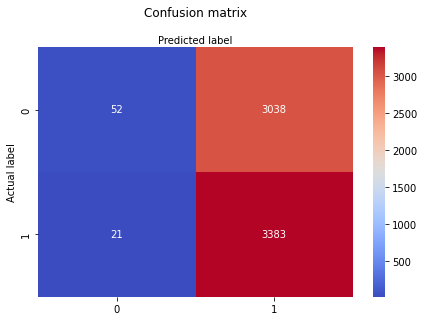

In [293]:
pipeline= Pipeline([
   ('preprocessor',preprocessor),
   ('clf',RandomForestClassifier(n_estimators=5,max_depth=1,min_samples_leaf=3, max_features=6, random_state=42))
])
pipeline.fit(X_train,y_train)

#Predicting y for X_val
y_pred = pipeline.predict(X)
cm = confusion_matrix(y,y_pred)

class_names=[1,2]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="coolwarm" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [294]:
print ("Look for the best parameters in the random forest classifier")

parameter_grid={'n_estimators':[100,150,200,250,280],'max_depth':[45,50,55,60,65,70],'min_samples_leaf':[1,2,4],'max_features':[2,3,4,5]}


number_models=4
random_RandomForest_class=RandomizedSearchCV(
    estimator=pipeline['clf'],
    param_distributions=parameter_grid,
    n_iter=number_models,
    scoring='accuracy',
    n_jobs=2,
    cv=k,
    refit=True,
    return_train_score=True)
pipeline= Pipeline([
   ('preprocessor',preprocessor),
   ('clf12',random_RandomForest_class)
])
cls = pipeline.fit(X_train,y_train)
predictions=pipeline.predict(X_test)

print("Accuracy Score",accuracy_score(y_test,predictions));
# print("Best params",random_RandomForest_class.best_params_)
# print("Best score",pipeline.best_score_)

Look for the best parameters in the random forest classifier
Accuracy Score 0.7183170856849667


In [295]:
print("Best params",random_RandomForest_class.best_params_)
print("Best score",random_RandomForest_class.best_score_)

Best params {'n_estimators': 250, 'min_samples_leaf': 1, 'max_features': 4, 'max_depth': 50}
Best score 0.712871287128713


In [296]:
import joblib
joblib.dump(cls, "class.pkl")

['class.pkl']